# Задание
1. Реализайте архитектуру GAN на датасете FashionMNIST, где генератор будет написан на архитектуре сверточной сети
2. Реализуйте архитектуру сверточной нейронной сети, которая будет обучена на датасете FashionMNIST, для классификации ваших сгенерированных изображений


In [ ]:
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import spectral_norm
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn


In [ ]:

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((.5,), (.5,))])

train_set = torchvision.datasets.FashionMNIST(root='.', train=True, download=True, transform=transform)

In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

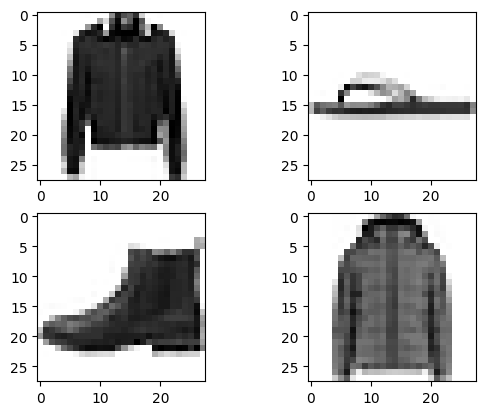

In [ ]:
real_sample, mnist_labels = next(iter(train_loader))

for i in range(4):
  ax = plt.subplot(2, 2, i + 1)
  plt.imshow(real_sample[i].squeeze(), cmap='gray_r')

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # 1x28x28 -> 64x14x14
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 64x14x14 -> 128x7x7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),  # 128x7x7 -> 1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 128, kernel_size=7, stride=1, padding=0),  # 100 -> 128x7x7
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 128x7x7 -> 64x14x14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),     # 64x14x14 -> 1x28x28
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(z.size(0), 100, 1, 1)  # Преобразование в формат (batch_size, 100, 1, 1)
        return self.model(z)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

gen = Generator().to(device)
desc = Descriminator().to(device)

In [ ]:
num_epochs = 25
lr = 0.0002
criterion = nn.BCELoss()
optimizer_D = torch.optim.Adam(desc.parameters(), lr=lr)
optimizer_G = torch.optim.Adam(gen.parameters(), lr=lr)

In [ ]:
from tqdm import tqdm

for epoch in tqdm(range(num_epochs)):
    for n, (real_samples, _) in enumerate(train_loader):
        real_samples = real_samples.to(device)
        real_labels = torch.ones((real_samples.size(0), 1), device=device)
        fake_labels = torch.zeros((real_samples.size(0), 1), device=device)

        # Шаг 1: Обучение дискриминатора
        noise = torch.randn(real_samples.size(0), 100, device=device)# Генерация шума для генератора
        fake_samples = gen(noise)# Генерация фейковых образцов генератором


        desc.zero_grad()# Обнуление градиентов дискриминатора
        real_loss = criterion(desc(real_samples), real_labels)# Вычисление функции потерь для реальных образцов
        fake_loss = criterion(desc(fake_samples.detach()), fake_labels)#Вычисление функции потерь для фейковых образцов (detach() отключает градиенты для генератора на этом шаге)
        loss_D = real_loss + fake_loss # Общая функция потерь дискриминатора
        loss_D.backward()
        optimizer_D.step()

        # Шаг 2: Обучение генератора
        gen.zero_grad() # Обнуление градиентов генератора
        output = desc(fake_samples) # Пропускание сгенерированных образцов через дискриминатор
        loss_G = criterion(output, real_labels) # Функция потерь генератора (стремится обмануть дискриминатор)
        loss_G.backward()
        optimizer_G.step()

    # Вывод метрик для каждого эпохи
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}")



  4%|▍         | 1/25 [03:08<1:15:28, 188.68s/it]

Epoch [1/25] | Loss D: 0.8014 | Loss G: 1.8463


  8%|▊         | 2/25 [06:19<1:12:47, 189.90s/it]

Epoch [2/25] | Loss D: 0.8745 | Loss G: 1.8193


 12%|█▏        | 3/25 [09:30<1:09:50, 190.46s/it]

Epoch [3/25] | Loss D: 1.0720 | Loss G: 1.4567


 16%|█▌        | 4/25 [12:44<1:07:05, 191.71s/it]

Epoch [4/25] | Loss D: 0.8809 | Loss G: 1.7270


 20%|██        | 5/25 [15:58<1:04:14, 192.74s/it]

Epoch [5/25] | Loss D: 0.8975 | Loss G: 1.3509


 24%|██▍       | 6/25 [19:11<1:01:03, 192.81s/it]

Epoch [6/25] | Loss D: 0.8399 | Loss G: 1.5095


 28%|██▊       | 7/25 [22:27<58:10, 193.90s/it]  

Epoch [7/25] | Loss D: 0.9723 | Loss G: 1.4455


 32%|███▏      | 8/25 [25:44<55:10, 194.72s/it]

Epoch [8/25] | Loss D: 0.9748 | Loss G: 1.2329


 36%|███▌      | 9/25 [29:00<52:02, 195.13s/it]

Epoch [9/25] | Loss D: 1.0396 | Loss G: 1.1768


 40%|████      | 10/25 [32:15<48:49, 195.27s/it]

Epoch [10/25] | Loss D: 1.0393 | Loss G: 1.2017


 44%|████▍     | 11/25 [35:30<45:28, 194.90s/it]

Epoch [11/25] | Loss D: 1.0822 | Loss G: 1.1560


 48%|████▊     | 12/25 [38:46<42:20, 195.46s/it]

Epoch [12/25] | Loss D: 1.0025 | Loss G: 1.2974


 52%|█████▏    | 13/25 [42:04<39:12, 196.08s/it]

Epoch [13/25] | Loss D: 0.9515 | Loss G: 1.2422


 56%|█████▌    | 14/25 [45:20<35:58, 196.22s/it]

Epoch [14/25] | Loss D: 0.8719 | Loss G: 1.2281


 60%|██████    | 15/25 [48:33<32:30, 195.04s/it]

Epoch [15/25] | Loss D: 0.8439 | Loss G: 1.7249


 64%|██████▍   | 16/25 [51:44<29:05, 193.95s/it]

Epoch [16/25] | Loss D: 1.0102 | Loss G: 1.3658


 68%|██████▊   | 17/25 [54:54<25:42, 192.79s/it]

Epoch [17/25] | Loss D: 0.9161 | Loss G: 1.4398


 72%|███████▏  | 18/25 [58:05<22:26, 192.29s/it]

Epoch [18/25] | Loss D: 1.0044 | Loss G: 1.3935


 76%|███████▌  | 19/25 [1:01:17<19:12, 192.06s/it]

Epoch [19/25] | Loss D: 0.8271 | Loss G: 1.4957


 80%|████████  | 20/25 [1:04:28<15:59, 191.82s/it]

Epoch [20/25] | Loss D: 0.9996 | Loss G: 1.3451


 84%|████████▍ | 21/25 [1:07:39<12:46, 191.60s/it]

Epoch [21/25] | Loss D: 0.7573 | Loss G: 1.5011


 88%|████████▊ | 22/25 [1:10:51<09:34, 191.57s/it]

Epoch [22/25] | Loss D: 0.9532 | Loss G: 1.3899


 92%|█████████▏| 23/25 [1:14:02<06:23, 191.66s/it]

Epoch [23/25] | Loss D: 1.1116 | Loss G: 1.5712


 96%|█████████▌| 24/25 [1:17:15<03:11, 191.97s/it]

Epoch [24/25] | Loss D: 1.0093 | Loss G: 1.2165


100%|██████████| 25/25 [1:20:28<00:00, 193.13s/it]

Epoch [25/25] | Loss D: 0.8922 | Loss G: 1.4384


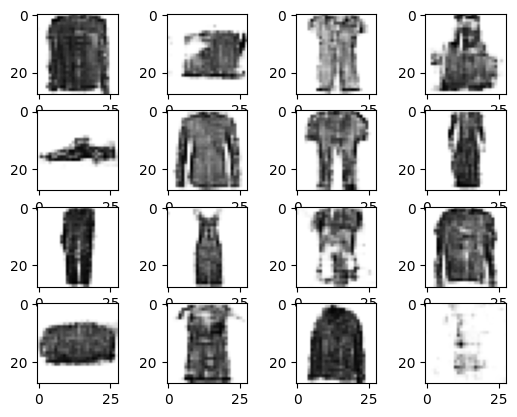

In [ ]:
noise = torch.randn(16, 100, device=device)
fake_samples = gen(noise).detach().cpu()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(fake_samples[i].squeeze(), cmap='gray_r')
plt.show()
#получились довольно неплохо, элементы одежды узнаваемы)

In [ ]:
#обучаем классификатор
test_data = torchvision.datasets.FashionMNIST(root = './NN_torch_simple/.', train = False, download = True, transform = transform)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.7MB/s]


Extracting ./NN_torch_simple/./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./NN_torch_simple/./FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 204kB/s]


Extracting ./NN_torch_simple/./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./NN_torch_simple/./FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.75MB/s]


Extracting ./NN_torch_simple/./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./NN_torch_simple/./FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 16.2MB/s]

Extracting ./NN_torch_simple/./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./NN_torch_simple/./FashionMNIST/raw



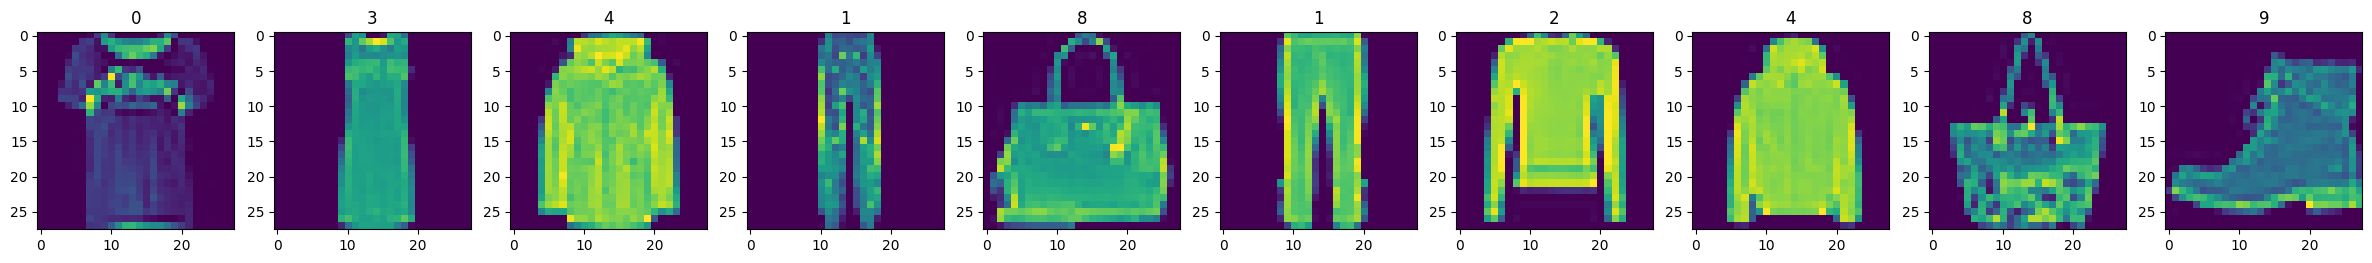

In [ ]:
test_loader = torch.utils.data.DataLoader(test_data,batch_size = len(test_data), shuffle = False)
dataiter = iter(train_loader)
images, labels = next(dataiter)
def show_images(img,labels):
    f, axes = plt.subplots(1,10,figsize = (30,5))
    for i,axis in enumerate(axes):
        axes[i].imshow(np.squeeze(np.transpose(img[i].numpy(),(1,2,0))))
        axes[i].set_title(labels[i].numpy())
    plt.show()

show_images(images,labels)

In [ ]:
name = {
    0 : "Футболка",
    1 : "Джинсы",
    2 : "Пуловеер",
    3 : "Платье",
    4 : "Пальто",
    5 : "Тапки",
    6 : "Рубашка",
    7 : "Кроссовки",
    8 : "Сумка",
    9 : "Ботинки",
}


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv15 = nn.Conv2d(6, 6, 1)
        self.conv2 = nn.Conv2d(6,batch_size,5)
        self.conv3 = nn.Conv2d(batch_size, batch_size, 1)
        self.pool = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(batch_size*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)


    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv15(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))

        x = x.view(-1, batch_size*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

In [ ]:
net = Net()
loss_net = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001,momentum = 0.9)

In [ ]:
epoch = 12

for ep in range(epoch): # Цикл по эпохам
    running_loss = 0.0 # Сброс накопленной функции потерь в начале каждой эпохи
    train_dataiter = iter(train_loader) # Создание итератора для загрузки данных из train_loader
    for i, batch in enumerate(train_dataiter): # Цикл по батчам данных в пределах эпохи
        X_batch, y_batch = batch # Распаковка батча на входные данные (X_batch) и метки (y_batch)
        optimizer.zero_grad() # Обнуление градиентов оптимизатора перед каждым шагом обучения
        y_pred = net(X_batch) # Прямое распространение: прогон входных данных через нейронную сеть
        loss = loss_net(y_pred, y_batch) # Вычисление функции потерь, сравнивая предсказанные значения (y_pred) с истинными метками (y_batch)
        loss.backward() # Обратное распространение ошибки: вычисление градиентов по всем параметрам сети
        optimizer.step() # Шаг оптимизации: обновление параметров сети на основе вычисленных градиентов
        running_loss += loss.item() # Накопление функции потерь
        if i % 500 == 499: # Вывод статистики каждые 500 батчей
            print(ep + 1, i + 1, running_loss / 500) # Вывод номера эпохи, номера батча и средней функции потерь за последние 500 батчей
            running_loss = 0.0 # Сброс накопленной функции потерь




1 500 0.35782831828296185
1 1000 0.3415294153690338
1 1500 0.3412727966606617
2 500 0.33944241000711917
2 1000 0.33907633647322655
2 1500 0.34541581308841707
3 500 0.33132676789164545
3 1000 0.3456566321104765
3 1500 0.3231969146430492
4 500 0.32556214186549187
4 1000 0.32459942069649694
4 1500 0.31993899711966517
5 500 0.31350429835915566
5 1000 0.32042354979366067
5 1500 0.31279959689080716
6 500 0.3084745055213571
6 1000 0.30733878050744534
6 1500 0.3165515210852027
7 500 0.307795180298388
7 1000 0.2982085535079241
7 1500 0.29605295449495317
8 500 0.30350495997816324
8 1000 0.29564195313304664
8 1500 0.29500149060040715
9 500 0.2862499869838357
9 1000 0.29388314777612684
9 1500 0.29557822258025407
10 500 0.2938659687563777
10 1000 0.27875277283787725
10 1500 0.2821507673934102
11 500 0.27726045744866135
11 1000 0.28082391249388455
11 1500 0.2815317942947149
12 500 0.27254847560077905
12 1000 0.2770936457142234
12 1500 0.27050091231614354


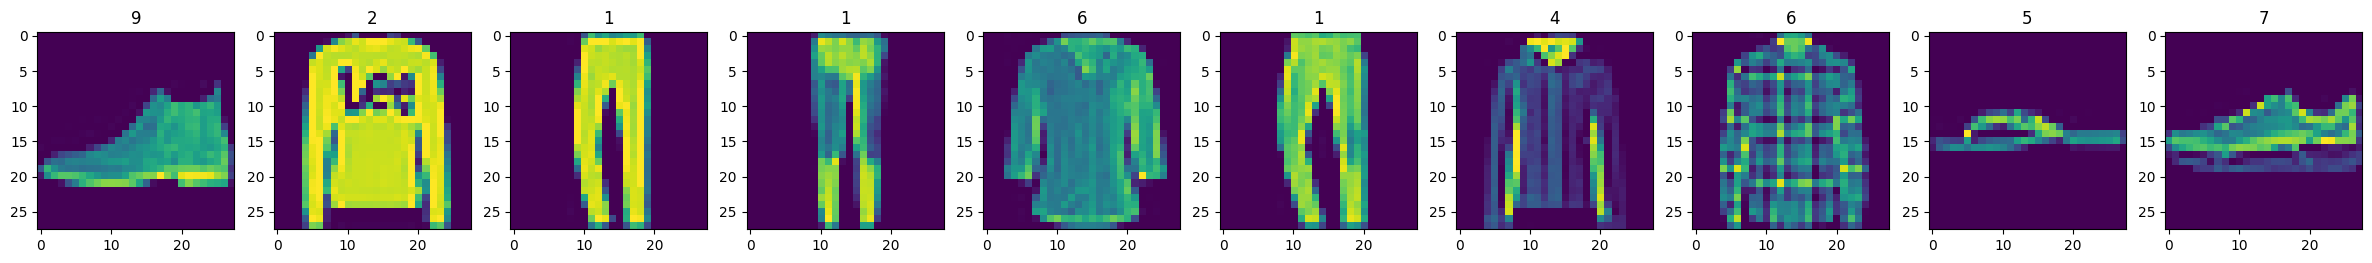

['Ботинки', 'Пуловеер', 'Джинсы', 'Джинсы', 'Рубашка', 'Джинсы', 'Пальто', 'Пальто', 'Тапки', 'Кроссовки']


In [ ]:
#тест1
test_dataiter = iter(test_loader)
images,labels = next(test_dataiter)
predict_classes = np.argmax(net.forward(images).detach().numpy(), axis =1)
show_images(images,labels)
print(list(map(lambda x: name[x], predict_classes))[:10])

In [ ]:
#метрики
target_names =["Футболка", "Штаны", "Полувеер", "Платье", "Пальто", "Сандали", "Рубашка", "Кроссовки", "Сумка", "Ботинки"]
print(classification_report(labels.numpy(), predict_classes, target_names = target_names))
#очень неплохо, для нашей задачи подойдет(можно еще поиграться)
#рубашка хуже всего классифицируется

              precision    recall  f1-score   support

    Футболка       0.88      0.78      0.83      1000
       Штаны       0.99      0.98      0.98      1000
    Полувеер       0.82      0.81      0.82      1000
      Платье       0.90      0.89      0.90      1000
      Пальто       0.83      0.78      0.80      1000
     Сандали       0.98      0.94      0.96      1000
     Рубашка       0.64      0.76      0.69      1000
   Кроссовки       0.88      0.99      0.93      1000
       Сумка       0.97      0.97      0.97      1000
     Ботинки       0.98      0.91      0.94      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



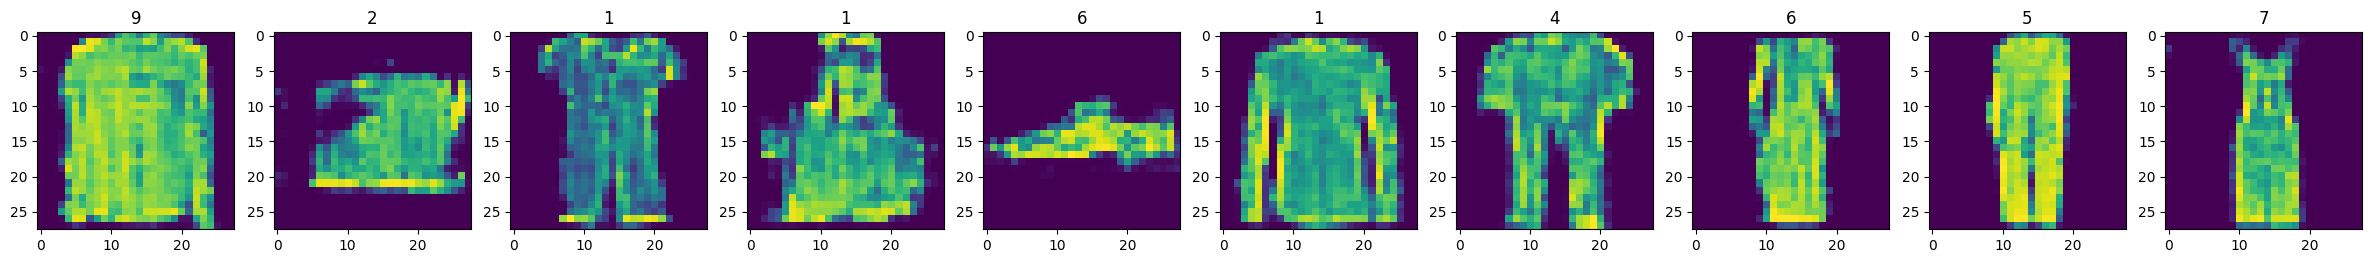

['Пуловеер',
 'Сумка',
 'Рубашка',
 'Сумка',
 'Кроссовки',
 'Пуловеер',
 'Футболка',
 'Платье',
 'Джинсы',
 'Платье']

In [ ]:
#тест2 (генерированный датасет)
predict_classes1 = np.argmax(net.forward(fake_samples).detach().numpy(), axis =1)
show_images(fake_samples, labels)
list(map(lambda x: name[x], predict_classes1))[:10]
#все определено верно!